# **Predicting by Originals**



<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title></title>
</head>
<body>
    <img src="https://drive.google.com/uc?export=view&id=1-RkKP4oFSkSoSfaLrT7UEtP9Va55WTRO" width="100%">
</body>
</html>


----------------------------------------------------------------------




# **Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import torch
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from matplotlib import style
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras import layers as tfkl
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout,LSTM,BatchNormalization, Activation
from sklearn.preprocessing import MinMaxScaler
from keras import callbacks
import os ,datetime,math,time

%matplotlib inline
warnings.filterwarnings('ignore')
#%load_ext tensorboard

In [ ]:
# Setting on Gpu
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


# **Load clean Dataset**

In [2]:
!gdown 1Td2yUesbc68Nf1Jq4-DNcGo5gWLbHQiK # Load clean dataset
!gdown 19_sOEpLtAJFh9fSqYEnuAquR-9SINaFy

#
path1 = '/content/clean_traffic_dataframe_with_outliers.csv'
path2 = '/content/clean_traffic_dataframe_without_outliers.csv'
raw_traffic_df = pd.read_csv(path1,index_col =0)
cleaned_traffic_df = pd.read_csv(path2,index_col =0)


print('*'*100)
print('raw_traffic_df are those ones with outliers')
print('cleaned_traffic_df are those ones without outliers')

Downloading...
From: https://drive.google.com/uc?id=1Td2yUesbc68Nf1Jq4-DNcGo5gWLbHQiK
To: /content/clean_traffic_dataframe_with_outliers.csv
100% 21.8M/21.8M [00:00<00:00, 127MB/s] 
Downloading...
From: https://drive.google.com/uc?id=19_sOEpLtAJFh9fSqYEnuAquR-9SINaFy
To: /content/clean_traffic_dataframe_without_outliers.csv
100% 21.8M/21.8M [00:00<00:00, 49.2MB/s]
****************************************************************************************************
raw_traffic_df are those ones with outliers
cleaned_traffic_df are those ones without outliers


In [3]:
raw_traffic_df

,src_id,dst_id,2005-01-01-00-30,2005-01-01-00-45,2005-01-01-01-00,2005-01-01-01-15,2005-01-01-01-30,2005-01-01-01-45,2005-01-01-02-00,2005-01-01-02-15,...,2005-01-31-21-30,2005-01-31-21-45,2005-01-31-22-00,2005-01-31-22-15,2005-01-31-22-30,2005-01-31-22-45,2005-01-31-23-00,2005-01-31-23-15,2005-01-31-23-30,2005-01-31-23-45
index,,,,,,,,,,,,,,,,,,,,,
traffic_0,12.0,12.0,396708.218750,338875.562500,341894.531250,347749.593750,320159.500000,336569.968750,304732.937500,318965.968750,...,311502.937500,317854.750000,315334.906250,320295.812500,318063.656250,320748.468750,298609.437500,297175.156250,305258.218750,310534.281250
traffic_1,12.0,13.0,28093.751953,28485.341797,38402.675781,31250.835938,50818.000000,20076.400391,33443.359375,40365.109375,...,30722.843750,31104.542969,47739.316406,35189.562500,33934.667969,30320.167969,25305.537109,26145.296875,28801.875000,30300.666016
traffic_2,12.0,19.0,16916.560547,11769.341797,5830.630859,7052.648926,6173.021973,4775.511230,5676.648926,4924.951172,...,3370.639893,1122.391113,1256.791138,2634.729004,3196.266602,4596.844238,7102.284180,5395.040039,4077.155518,10089.449219
traffic_3,12.0,23.0,3662.808838,1950.506714,2293.377686,1915.724365,1556.533325,1623.608887,1072.942261,855.422180,...,194.088898,726.826721,4217.244629,16669.822266,17209.421875,8732.426758,62.880001,412.213287,166.906693,119.040001
traffic_4,12.0,8.0,6552.933105,5445.911133,5831.057617,5757.155762,5453.600098,5178.399902,7083.333496,8414.426758,...,2915.893311,2589.146729,4792.293457,4280.568848,3852.213379,2539.466797,2017.928955,1540.204346,1812.302246,1205.466675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
traffic_434,15.0,2.0,1326.924438,572.444397,533.786682,556.604370,575.795593,628.737793,446.000000,586.044373,...,208.284393,111.973297,119.324402,182.293304,111.555603,198.826706,123.555603,43.866699,51.306702,935.715576
traffic_435,15.0,11.0,496.471100,493.484406,292.071106,182.488907,267.822205,51.137798,103.173302,135.279999,...,19.004400,0.880000,8.266700,1.564400,16.835600,14.720000,0.435600,0.462200,13.600000,13.866700
traffic_436,15.0,9.0,3781.964355,888.728882,1063.511108,1211.875610,1142.719971,1020.337830,844.088928,1155.155640,...,1019.119995,2097.875488,2995.155518,5178.213379,3393.697754,508.044403,977.688904,1867.662231,296.853302,299.715607


In [4]:
cleaned_traffic_df

,src_id,dst_id,2005-01-01-00-30,2005-01-01-00-45,2005-01-01-01-00,2005-01-01-01-15,2005-01-01-01-30,2005-01-01-01-45,2005-01-01-02-00,2005-01-01-02-15,...,2005-01-31-21-30,2005-01-31-21-45,2005-01-31-22-00,2005-01-31-22-15,2005-01-31-22-30,2005-01-31-22-45,2005-01-31-23-00,2005-01-31-23-15,2005-01-31-23-30,2005-01-31-23-45
index,,,,,,,,,,,,,,,,,,,,,
traffic_0,12.0,12.0,396708.218750,338875.562500,341894.531250,347749.593750,320159.500000,336569.968750,304732.937500,318965.968750,...,311502.937500,317854.750000,315334.906250,320295.812500,318063.656250,320748.468750,298609.437500,297175.156250,305258.218750,310534.281250
traffic_1,12.0,13.0,28093.751953,28485.341797,38402.675781,31250.835938,50818.000000,20076.400391,33443.359375,40365.109375,...,30722.843750,31104.542969,47739.316406,35189.562500,33934.667969,30320.167969,25305.537109,26145.296875,28801.875000,30300.666016
traffic_2,12.0,19.0,16916.560547,11769.341797,5830.630859,7052.648926,6173.021973,4775.511230,5676.648926,4924.951172,...,3370.639893,1122.391113,1256.791138,2634.729004,3196.266602,4596.844238,7102.284180,5395.040039,4077.155518,10089.449219
traffic_3,12.0,23.0,3662.808838,1950.506714,2293.377686,1915.724365,1556.533325,1623.608887,1072.942261,855.422180,...,194.088898,726.826721,4217.244629,4217.244629,4217.244629,8732.426758,62.880001,412.213287,166.906693,119.040001
traffic_4,12.0,8.0,6552.933105,5445.911133,5831.057617,5757.155762,5453.600098,5178.399902,7083.333496,8414.426758,...,2915.893311,2589.146729,4792.293457,4280.568848,3852.213379,2539.466797,2017.928955,1540.204346,1812.302246,1205.466675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
traffic_434,15.0,2.0,1326.924438,572.444397,533.786682,556.604370,575.795593,628.737793,446.000000,586.044373,...,208.284393,111.973297,119.324402,182.293304,111.555603,198.826706,123.555603,43.866699,51.306702,935.715576
traffic_435,15.0,11.0,496.471100,493.484406,292.071106,182.488907,267.822205,51.137798,103.173302,135.279999,...,19.004400,0.880000,8.266700,1.564400,16.835600,14.720000,0.435600,0.462200,13.600000,13.866700
traffic_436,15.0,9.0,3781.964355,888.728882,1063.511108,1211.875610,1142.719971,1020.337830,844.088928,1155.155640,...,1019.119995,2097.875488,2995.155518,5178.213379,3393.697754,508.044403,977.688904,1867.662231,296.853302,299.715607


In [ ]:
row = 5

# **Step One: Run our models**

## a) Define  Callbacks
to have better control on traing part

In [ ]:
def checkpoint(path,metrics='val_loss',save_weights_only=False):

    root_folder = 'Checkpint_Folder'
    filename = 'cp.keras'
    # Join them to create the full path
    full_path = os.path.join(root_folder,path, filename)
    checkpoint_path = full_path
    checkpoint_dir =os.path.dirname(full_path)
    check =callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                          monitor=metrics,
                                          verbose=1,
                                          save_weights_only = save_weights_only,
                                          save_best_only=True,
                                          mode='auto',
                                          save_freq ='epoch')

    return check
#############################################
def early_stopping(metrics='val_loss'):

    early = callbacks.EarlyStopping(monitor=metrics,
                                                  min_delta=.02,
                                                  patience=8,
                                                  verbose=1,
                                                  mode="auto")

    return early

#############################################
def tensor_board(path):

    logdir = os.path.join("TensorBoardlogs_Folder",path, datetime.datetime.now().strftime("%Y%m%d-%H%M"))
    tensor = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    return tensor

## b) Define Hyperparameters

In [ ]:
import random
Epochs = 200
Batch_size = 2
window_size = 20
period = 96
split_train_test_portion = 0.1
validation_portion = 0.1 # Allocate 10 % of train_data to validation
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

## c) Split dataset to train and test part

In [ ]:
def split_train_test(row,split_train_test_portion, dataframe,normalization=False):
    df = dataframe.copy()   # Forcast by Originals
    df.drop(['src_id','dst_id'],axis=1,inplace=True) # Remove src and dst as we don't need them now


    item = int(dataframe.shape[1] * split_train_test_portion)
    # Since we need to work on Originals, we have
    train_part_dataframe = df.iloc[row,:-item] # Choose 2700 timestamps for training
    test_part_dataframe = df.iloc[row,-item:]  # Choose the rest timestamps for testing
    print('train_part_dataframe.shape: ',train_part_dataframe.shape)
    print('test_part_dataframe.shape: ',test_part_dataframe.shape)


    if normalization ==True:
        #train_names = train_part_dataframe.columns
        #test_names = test_part_dataframe.columns
        scaler = MinMaxScaler(feature_range=(0, 1)) #F: The motivation to use this scaling include robustness to very small standard deviations of features and preserving zero entries in sparse data

        train_part_dataframe = np.reshape(train_part_dataframe,(train_part_dataframe.shape[0],1))
        train_part_dataframe = scaler.fit_transform(train_part_dataframe)
        train_part_dataframe = pd.DataFrame(train_part_dataframe)
        #train_part_dataframe.columns = train_names

        test_part_dataframe = np.reshape(test_part_dataframe,(test_part_dataframe.shape[0],1))
        test_part_dataframe = scaler.transform(test_part_dataframe)
        test_part_dataframe = pd.DataFrame(test_part_dataframe)
        #test_part_dataframe.columns = test_names
        #test_part_dataframe = scaler.transform(test_part_dataframe)
        return train_part_dataframe, test_part_dataframe, scaler

    return train_part_dataframe, test_part_dataframe

In [ ]:
print('We split the residual_dataframe into two bellow parts:')
print('*'*100)
print('For raw_traffic_df:')
train_part_dataframe_with_outliers, test_part_dataframe_with_outliers= split_train_test(row,split_train_test_portion=split_train_test_portion,
                                                                                         dataframe=raw_traffic_df)


We split the residual_dataframe into two bellow parts:
****************************************************************************************************
For raw_traffic_df:
train_part_dataframe.shape:  (2647,)
test_part_dataframe.shape:  (294,)


## d) Prepare X_train, y_train

In [ ]:
def create_sequences(train_part_dataframe,test_part_dataframe,row, window_size):
    """
    Input: dataframe, row, windows_size, prediction_size
    Output: X_train, y_train
    This function tries to prepare X_train and y_train
    """

    # For training part
    ####################################################
    train_row = train_part_dataframe.copy()
    train_row = np.reshape(train_row, (-1,1))
    X_train = list()
    y_train = list()



    for i in range(window_size, len(train_row)):
        X_train.append(train_row[i-window_size:i, 0])
        y_train.append(train_row[i, 0])




    # Turn to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    # Reshaping to be appropriate for models
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
    y_train = np.reshape(y_train, (y_train.shape[0],1))


    # For testing part
    ####################################################
    test_row = test_part_dataframe.copy()
    test_row = np.reshape(test_row, (-1,1))
    X_test = list()
    y_test = list()



    for i in range(window_size, len(test_row)):
      X_test.append(test_row[i-window_size:i, 0])
      y_test.append(test_row[i, 0])


    # Turn to numpy array
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    # Reshaping to be appropriate for models
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
    y_test = np.reshape(y_test, (y_test.shape[0],1))

    return  X_train, y_train,X_test,y_test


In [ ]:
# Call function
X_train_with_outliers, y_train_with_outliers,X_test_with_outliers, y_test_with_outliers = create_sequences(train_part_dataframe=train_part_dataframe_with_outliers,
                                                                                                           test_part_dataframe=test_part_dataframe_with_outliers,
                                                                                                           row=row, window_size=window_size)
print(f'These information are for traffic {row} with outliers')
print('*'*100)
print('X_train.shape: ',X_train_with_outliers.shape)
print('Y_train.shape: ',y_train_with_outliers.shape)
print('X_test.shape: ',X_test_with_outliers.shape)
print('Y_test.shape: ',y_test_with_outliers.shape)




These information are for traffic 5 with outliers
****************************************************************************************************
X_train.shape:  (2627, 20, 1)
Y_train.shape:  (2627, 1)
X_test.shape:  (274, 20, 1)
Y_test.shape:  (274, 1)


## e) Model 1: Local RNN

### e_1) Define model

In [ ]:
def RNN(input_shape):

	# initializing the RNN
	rnn = Sequential()

	# adding RNN layers and dropout regularization
	rnn.add(SimpleRNN(units = 50,
							activation = "tanh",
							return_sequences = True,
							input_shape = input_shape))
	rnn.add(Dropout(0.2))

	rnn.add(SimpleRNN(units = 50,
							activation = "tanh",
							return_sequences = True))

	rnn.add(SimpleRNN(units = 50,
							activation = "tanh",
							return_sequences = True))

	rnn.add( SimpleRNN(units = 50))

	# adding the output layer
	rnn.add(Dense(units = 1))

	# compiling RNN
	rnn.compile(optimizer = 'adam',
												loss = 'mean_squared_error'
												)



	return rnn
#%tensorboard --logdir TensorBoardlogs_Folder/ "--load_fast=false"

### e_2) Train Model

In [ ]:
# Set callbacks
print(f'This is training for traffic_{row} with outliers')
print('*'*100)

path = f"/content/RNN_on_Original_for_traffic_{row}_with_outliers"
my_checkpoints = checkpoint(path=path,metrics='val_loss',save_weights_only=False)
my_eraly_stops = early_stopping()
my_tensors =  tensor_board(path=path)
my_defined_callbacks = [my_checkpoints, my_eraly_stops, my_tensors]

# Call model
input_shape = (window_size,1)
rnn_with_outliers = RNN(input_shape)
rnn_with_outliers.summary()

# fitting the model
start = time.time()
rnn_with_outliers.fit(X_train_with_outliers,
                      y_train_with_outliers,
                      epochs = Epochs,validation_split=0.1,
                      batch_size = Batch_size,
                      callbacks=my_defined_callbacks)
stop = time.time()
training_time = round((stop-start),0)

This is training for traffic_5 with outliers
****************************************************************************************************


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 20, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 20, 50)         │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 20, 50)         │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,801 (69.54 KB)

 Trainable params: 17,801 (69.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
   5/1182 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 37685649408.0000  

I0000 00:00:1720535580.198096      74 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1176/1182 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 379783422672896.0000
Epoch 1: val_loss improved from inf to 26249326592.00000, saving model to Checkpint_Folder/RNN_on_Original_for_traffic_5_with_outliers/cp.keras
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 381649552408576.0000 - val_loss: 26249326592.0000
Epoch 2/200
1180/1182 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 380855184785408.0000
Epoch 2: val_loss improved from 26249326592.00000 to 26248900608.00000, saving model to Checkpint_Folder/RNN_on_Original_for_traffic_5_with_outliers/cp.keras
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 381649552408576.0000 - val_loss: 26248900608.0000
Epoch 3/200
1176/1182 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 379783422672896.0000
Epoch 3: val_loss improved from 26248900608.00000 to 26248478720.00000, saving model to Checkpint_Folder/RNN_on_Original_for_traffic_5_with_outliers/cp.keras
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 381649552408576.0000 - val_loss: 26248478720.0

### e_3) Result

In [ ]:
def performance(model_name,prediction_type, operations_on_input, row, y_true, y_pred,training_time):
    global raw_traffic_df


    # Extract relevant ids from clean_df
    src_id = raw_traffic_df.iloc[row, 0]
    dst_id = raw_traffic_df.iloc[row, 1]
    y_true = np.squeeze(y_true)
    y_pred = np.squeeze(y_pred)

    # Calculate metrics
    mean_squared_error = mse(y_true=y_true, y_pred=y_pred)
    mean_absolute_error = mae(y_true=y_true, y_pred=y_pred)
    mean_absolute_percentage_error = mape(y_true=y_true, y_pred=y_pred)

    # Create a new row of result
    performance_df = pd.DataFrame({
        "Traffic_id":[row],
        "Src_id": [src_id],
        "Dst_id": [dst_id],
        "Model": [model_name],
        "Prediction_type":[prediction_type],
        "Input":[operations_on_input],
        "Training_time[s]": [training_time],
        "MAE": [mean_absolute_error],
        "MSE": [mean_squared_error],
        "MAPE[%]": [mean_absolute_percentage_error*100],
    })

    # Append the new row to the existing performance_df


    return performance_df


In [ ]:
# Prediction and performance on dataset with outliers
y_test_pred_with_outliers = rnn_with_outliers.predict(X_test_with_outliers)
rnn_perforamnce_with_outliers = performance(model_name='Model_1: RNN',
                                            prediction_type='Prediction_on_Original',
                                            operations_on_input="with_outliers",row = row,
                                            y_true=y_test_with_outliers,
                                            y_pred=y_test_pred_with_outliers,
                                            training_time =training_time )

display(rnn_perforamnce_with_outliers)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step


,Traffic_id,Src_id,Dst_id,Model,Prediction_type,Input,Training_time[s],MAE,MSE,MAPE[%]
0,5,12.0,18.0,Model_1: RNN,Prediction_on_Original,with_outliers,1827.0,133276.591594,2.276352e+10,99.676072


### e_4) Effect of removing outliers

In [ ]:
# Call section c) Split dataset to train and test without ouliers
print('For cleaned_traffic_df to see effect of removing')
print('*'*100)
train_part_dataframe_without_outliers, test_part_dataframe_without_outliers = split_train_test(row,split_train_test_portion=split_train_test_portion,
                                                                                               dataframe=cleaned_traffic_df)

# Call section d) Prepare X_train and y_train

X_train_without_outliers, y_train_without_outliers,X_test_without_outliers, y_test_without_outliers = create_sequences(train_part_dataframe=train_part_dataframe_without_outliers,
                                                                                                                       test_part_dataframe=test_part_dataframe_without_outliers,
                                                                                                                       row=row, window_size=window_size)
print(f'\n\nThese information are for traffic {row} without outliers.')
print('*'*100)
print('X_train.shape: ',X_train_without_outliers.shape)
print('Y_train.shape: ',y_train_without_outliers.shape)
print('X_test.shape: ',X_test_without_outliers.shape)
print('Y_test.shape: ',y_test_without_outliers.shape)


# Call section e_2) Train model
print(f'This is training for traffic_{row} without outliers')
print('*'*100)
path = f"/content/RNN_on_Original_for_traffic_{row}_with_outliers"
my_checkpoints = checkpoint(path=path,metrics='val_loss',save_weights_only=False)
my_eraly_stops = early_stopping()
my_tensors =  tensor_board(path=path)
my_defined_callbacks = [my_checkpoints, my_eraly_stops, my_tensors]

input_shape = (window_size,1)
rnn_without_outliers = RNN(input_shape)
rnn_without_outliers.summary()
start = time.time()
rnn_without_outliers.fit(X_train_without_outliers, y_train_without_outliers, epochs=Epochs,validation_split=0.1, batch_size = Batch_size, callbacks=my_defined_callbacks)
stop = time.time()
training_time = round((stop-start),0)


For cleaned_traffic_df to see effect of removing
****************************************************************************************************
train_part_dataframe.shape:  (2647,)
test_part_dataframe.shape:  (294,)


These information are for traffic 5 without outliers.
****************************************************************************************************
X_train.shape:  (2627, 20, 1)
Y_train.shape:  (2627, 1)
X_test.shape:  (274, 20, 1)
Y_test.shape:  (274, 1)
This is training for traffic_5 without outliers
****************************************************************************************************


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)        │ (None, 20, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 20, 50)         │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_6 (SimpleRNN)        │ (None, 20, 50)         │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,801 (69.54 KB)

 Trainable params: 17,801 (69.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
1177/1182 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5309399552.0000
Epoch 1: val_loss improved from inf to 22716506112.00000, saving model to Checkpint_Folder/RNN_on_Original_for_traffic_5_with_outliers/cp.keras
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - loss: 5311108608.0000 - val_loss: 22716506112.0000
Epoch 2/200
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5306845184.0000
Epoch 2: val_loss improved from 22716506112.00000 to 22704914432.00000, saving model to Checkpint_Folder/RNN_on_Original_for_traffic_5_with_outliers/cp.keras
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 5307125760.0000 - val_loss: 22704914432.0000
Epoch 3/200
1179/1182 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5302169600.0000
Epoch 3: val_loss improved from 22704914432.00000 to 22693361664.00000, saving model to Checkpint_Folder/RNN_on_Original_for_traffic_5_with_outliers/cp.keras
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 5303302144.0000 - val_loss: 22693361664.0000
Epoch 4/200
11

In [ ]:
# Call e_3) Result
y_test_pred_without_outliers = rnn_without_outliers.predict(X_test_without_outliers)
rnn_perforamnce_without_outliers = performance(model_name='Model_1: RNN',
                                               prediction_type='Prediction_on_Original',
                                               operations_on_input="without_outliers",
                                               row = row,
                                               y_true=y_test_without_outliers,
                                               y_pred=y_test_pred_without_outliers,
                                               training_time = training_time)

rnn_perforamnce_without_outliers = pd.concat([rnn_perforamnce_with_outliers,rnn_perforamnce_without_outliers],axis =0)
rnn_perforamnce_without_outliers.reset_index(inplace=True)
rnn_perforamnce_without_outliers.drop(['index'],axis= 1,inplace=True)
display(rnn_perforamnce_without_outliers)



9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step


,Traffic_id,Src_id,Dst_id,Model,Prediction_type,Input,Training_time[s],MAE,MSE,MAPE[%]
0,5,12.0,18.0,Model_1: RNN,Prediction_on_Original,with_outliers,1827.0,133276.591594,2.276352e+10,99.676072
1,5,12.0,18.0,Model_1: RNN,Prediction_on_Original,without_outliers,1848.0,121079.733648,1.904694e+10,91.926327


### e_5) Effect of Normalizing

In [ ]:

# Call section c)Split datsaset to train and test with normalization=True
train_part_dataframe_without_outliers_normalized, test_part_dataframe_without_outliers_normalized,scaler = split_train_test(row,split_train_test_portion=split_train_test_portion,
                                                                                               dataframe=cleaned_traffic_df,
                                                                                               normalization=True)
# Call section d) Prepare X_train, y_train
X_train_without_outliers_normalized, y_train_without_outliers_normalized,X_test_without_outliers_normalized, y_test_without_outliers_normalized = create_sequences(train_part_dataframe=train_part_dataframe_without_outliers_normalized,
                                                                                                                       test_part_dataframe=test_part_dataframe_without_outliers_normalized,
                                                                                                                       row=row, window_size=window_size)
print(f'\n\nThese information are for traffic {row} without_outliers with noramlization.')
print('*'*100)
print('X_train.shape: ',X_train_without_outliers_normalized.shape)
print('Y_train.shape: ',y_train_without_outliers_normalized.shape)
print('X_test.shape: ',X_test_without_outliers_normalized.shape)
print('Y_test.shape: ',y_test_without_outliers_normalized.shape)

# Call section e_2) Train model

print(f'This is training for traffic_{row} without outliers normalized')
print('*'*100)
path = f"/content/RNN_on_Original_for_traffic_{row}_with_outliers_normalized"
my_checkpoints = checkpoint(path=path,metrics='val_loss',save_weights_only=False)
my_eraly_stops = early_stopping()
my_tensors =  tensor_board(path=path)
my_defined_callbacks = [my_checkpoints, my_eraly_stops, my_tensors]


rnn_without_outliers_normalized = RNN(input_shape)
rnn_without_outliers_normalized.summary()
start = time.time()
rnn_without_outliers_normalized.fit(X_train_without_outliers_normalized, y_train_without_outliers_normalized,
                                    epochs = Epochs,validation_split=0.1, batch_size = Batch_size, callbacks=my_defined_callbacks)
stop = time.time()
training_time = round((stop-start),0)



train_part_dataframe.shape:  (2647,)
test_part_dataframe.shape:  (294,)


These information are for traffic 5 without_outliers with noramlization.
****************************************************************************************************
X_train.shape:  (2627, 20, 1)
Y_train.shape:  (2627, 1)
X_test.shape:  (274, 20, 1)
Y_test.shape:  (274, 1)
This is training for traffic_5 without outliers normalized
****************************************************************************************************


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_8 (SimpleRNN)        │ (None, 20, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_9 (SimpleRNN)        │ (None, 20, 50)         │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_10 (SimpleRNN)       │ (None, 20, 50)         │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_11 (SimpleRNN)       │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,801 (69.54 KB)

 Trainable params: 17,801 (69.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
1181/1182 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0428
Epoch 1: val_loss improved from inf to 0.00879, saving model to Checkpint_Folder/RNN_on_Original_for_traffic_5_with_outliers_normalized/cp.keras
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 0.0428 - val_loss: 0.0088
Epoch 2/200
1176/1182 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027
Epoch 2: val_loss improved from 0.00879 to 0.00633, saving model to Checkpint_Folder/RNN_on_Original_for_traffic_5_with_outliers_normalized/cp.keras
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0027 - val_loss: 0.0063
Epoch 3/200
1180/1182 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023
Epoch 3: val_loss improved from 0.00633 to 0.00594, saving model to Checkpint_Folder/RNN_on_Original_for_traffic_5_with_outliers_normalized/cp.keras
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0023 - val_loss: 0.0059
Epoch 4/200
1180/1182 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018
Epoch 4: val_loss did not improve from 0.0

In [ ]:
# Call section e_3) Result
y_test_pred_without_outliers_normalized = rnn_without_outliers_normalized.predict(X_test_without_outliers_normalized)
rnn_perforamnce_without_outliers_normalized = performance(model_name='Model_1: RNN',
                                               prediction_type='Prediction_on_Original',
                                               operations_on_input="normalized_without_outliers",row = row,
                                               y_true=y_test_without_outliers_normalized,
                                               y_pred=y_test_pred_without_outliers_normalized,training_time=training_time )

rnn_perforamnce_without_outliers_normalized = pd.concat([rnn_perforamnce_without_outliers,rnn_perforamnce_without_outliers_normalized],axis =0)
rnn_perforamnce_without_outliers_normalized.reset_index(inplace=True)
rnn_perforamnce_without_outliers_normalized.drop(['index'],axis= 1,inplace=True)
display(rnn_perforamnce_without_outliers_normalized)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step


,Traffic_id,Src_id,Dst_id,Model,Prediction_type,Input,Training_time[s],MAE,MSE,MAPE[%]
0,5,12.0,18.0,Model_1: RNN,Prediction_on_Original,with_outliers,1827.0,133276.591594,2.276352e+10,99.676072
1,5,12.0,18.0,Model_1: RNN,Prediction_on_Original,without_outliers,1848.0,121079.733648,1.904694e+10,91.926327
2,5,12.0,18.0,Model_1: RNN,Prediction_on_Original,normalized_without_outliers,97.0,0.046759,4.792304e-03,9.732413


In [ ]:
rnn_perforamnce_without_outliers_normalized.to_csv('Performance_df_of_rnn_on_Orginal.csv',index=True)

### e_6) Plot best prediction

In [ ]:
cleaned_traffic_df_normalized = pd.concat([train_part_dataframe_without_outliers_normalized,test_part_dataframe_without_outliers_normalized],axis=0)
cleaned_traffic_df_normalized.reset_index(inplace=True)
cleaned_traffic_df_normalized.drop(['index'],axis=1,inplace=True)

In [ ]:
def plot_results(scaler,cleaned_traffic_df, cleaned_traffic_df_normalized,
                 rnn_without_outliers_normalized ,
                 train_part_dataframe_without_outliers,train_part_dataframe_without_outliers_normalized
                 ,test_part_dataframe_without_outliers,test_part_dataframe_without_outliers_normalized):
        print('hi')
        # Set values
        ################################################################
        model = rnn_without_outliers_normalized
        src_id = cleaned_traffic_df.iloc[row,0]
        dst_id = cleaned_traffic_df.iloc[row,1]
        train_part_normalized = train_part_dataframe_without_outliers_normalized[20:]
        test_part_normalized = test_part_dataframe_without_outliers_normalized



        data1 = cleaned_traffic_df.iloc[row,2:]
        timestamps1 = cleaned_traffic_df.columns
        timestamps1 = timestamps1[2:]
        positions1 = range(0, len(data1), 100) # Define the positions for x-ticks (e.g., every 50th point)
        labels1 = [timestamps1[i] for i in positions1]       # Define the corresponding labels for these positions

        # Prepare again all data
        ################################################################
        all_data = cleaned_traffic_df_normalized
        all_data = np.reshape(all_data, (-1,1))

        X_all_true = list()
        y_all_true = list()

        for i in range(window_size, len(all_data)):
            X_all_true.append(all_data[i-window_size:i, 0])
            y_all_true.append(all_data[i, 0])


        # Turn to numpy array
        X_all_true = np.array(X_all_true)
        y_all_true = np.array(y_all_true)
        # Reshaping to be appropriate for models
        X_all_true = np.reshape(X_all_true, (X_all_true.shape[0], X_all_true.shape[1],1))
        y_all_true = np.reshape(y_all_true, (y_all_true.shape[0],1))




        #Predict
        ################################################################
        y_all_pred = model.predict(X_all_true)
        y_all_pred = np.squeeze(y_all_pred)


        # Generate the plots
        plt.style.use('ggplot')
        fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(20, 15))



        # Plot 1: Normalized traffic prediction
        ax1.plot(np.arange(len(train_part_normalized)), train_part_normalized, label='Normalized Original Traffic', color='g')
        ax1.plot(len(train_part_normalized) + np.arange(len(test_part_normalized)), test_part_normalized, color='g')
        ax1.plot(np.arange(len(y_all_pred)), y_all_pred, label='Normalized Predicted Traffic', color='b')

        vline_position = len(train_part_normalized)
        ax1.axvline(x=vline_position, color='r', linestyle='--', linewidth=3, label='Train Test Boundary')
        ax1.grid(True, color='brown', linestyle='--', alpha=0.5)

        ax1.set_title(f'Prediction On Original Traffic_{row} with src_id:{int(src_id)},and dst_id:{int(dst_id)}', fontweight='bold', fontsize=25)
        ax1.legend(fontsize=20)
        ax1.set_xticks([])
        ax1.tick_params(axis='x', labelsize=18)
        ax1.tick_params(axis='y', labelsize=18)

        # Show the combined plot


        # Plot2 Original traffic Prediction
        y_all_pred = np.reshape(y_all_pred,(len(y_all_pred),1))

        y_all_pred = scaler.inverse_transform(y_all_pred)
        train_part = train_part_dataframe_without_outliers[20:]
        test_part = test_part_dataframe_without_outliers


        ax2.plot(np.arange(len(train_part)), train_part, label='Original Traffic', color='g')
        ax2.plot(len(train_part) + np.arange(len(test_part)), test_part, color='g')
        ax2.plot(np.arange(len(y_all_pred)), y_all_pred, label='Predicted Traffic', color='b')

        vline_position = len(train_part)
        ax2.axvline(x=vline_position, color='r', linestyle='--', linewidth=3, label='Train Test Boundary')
        ax2.grid(True, color='brown', linestyle='--', alpha=0.5)
        ax2.set_xticks(positions1)
        ax2.set_xticklabels(labels1, rotation=90)
        ax2.set_ylabel('Traffic [Kbit/s]', fontsize=27)
        ax2.set_xlabel('Timestamps', fontsize=27)
        ax2.legend(fontsize=20)
        ax2.tick_params(axis='x', labelsize=18)
        ax2.tick_params(axis='y', labelsize=18)

        # Show the combined plot
        plt.tight_layout()
        plt.show()
        fig.savefig(f'Prediction_graph_for_traffic_{row}.png',dpi= 300)




hi
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


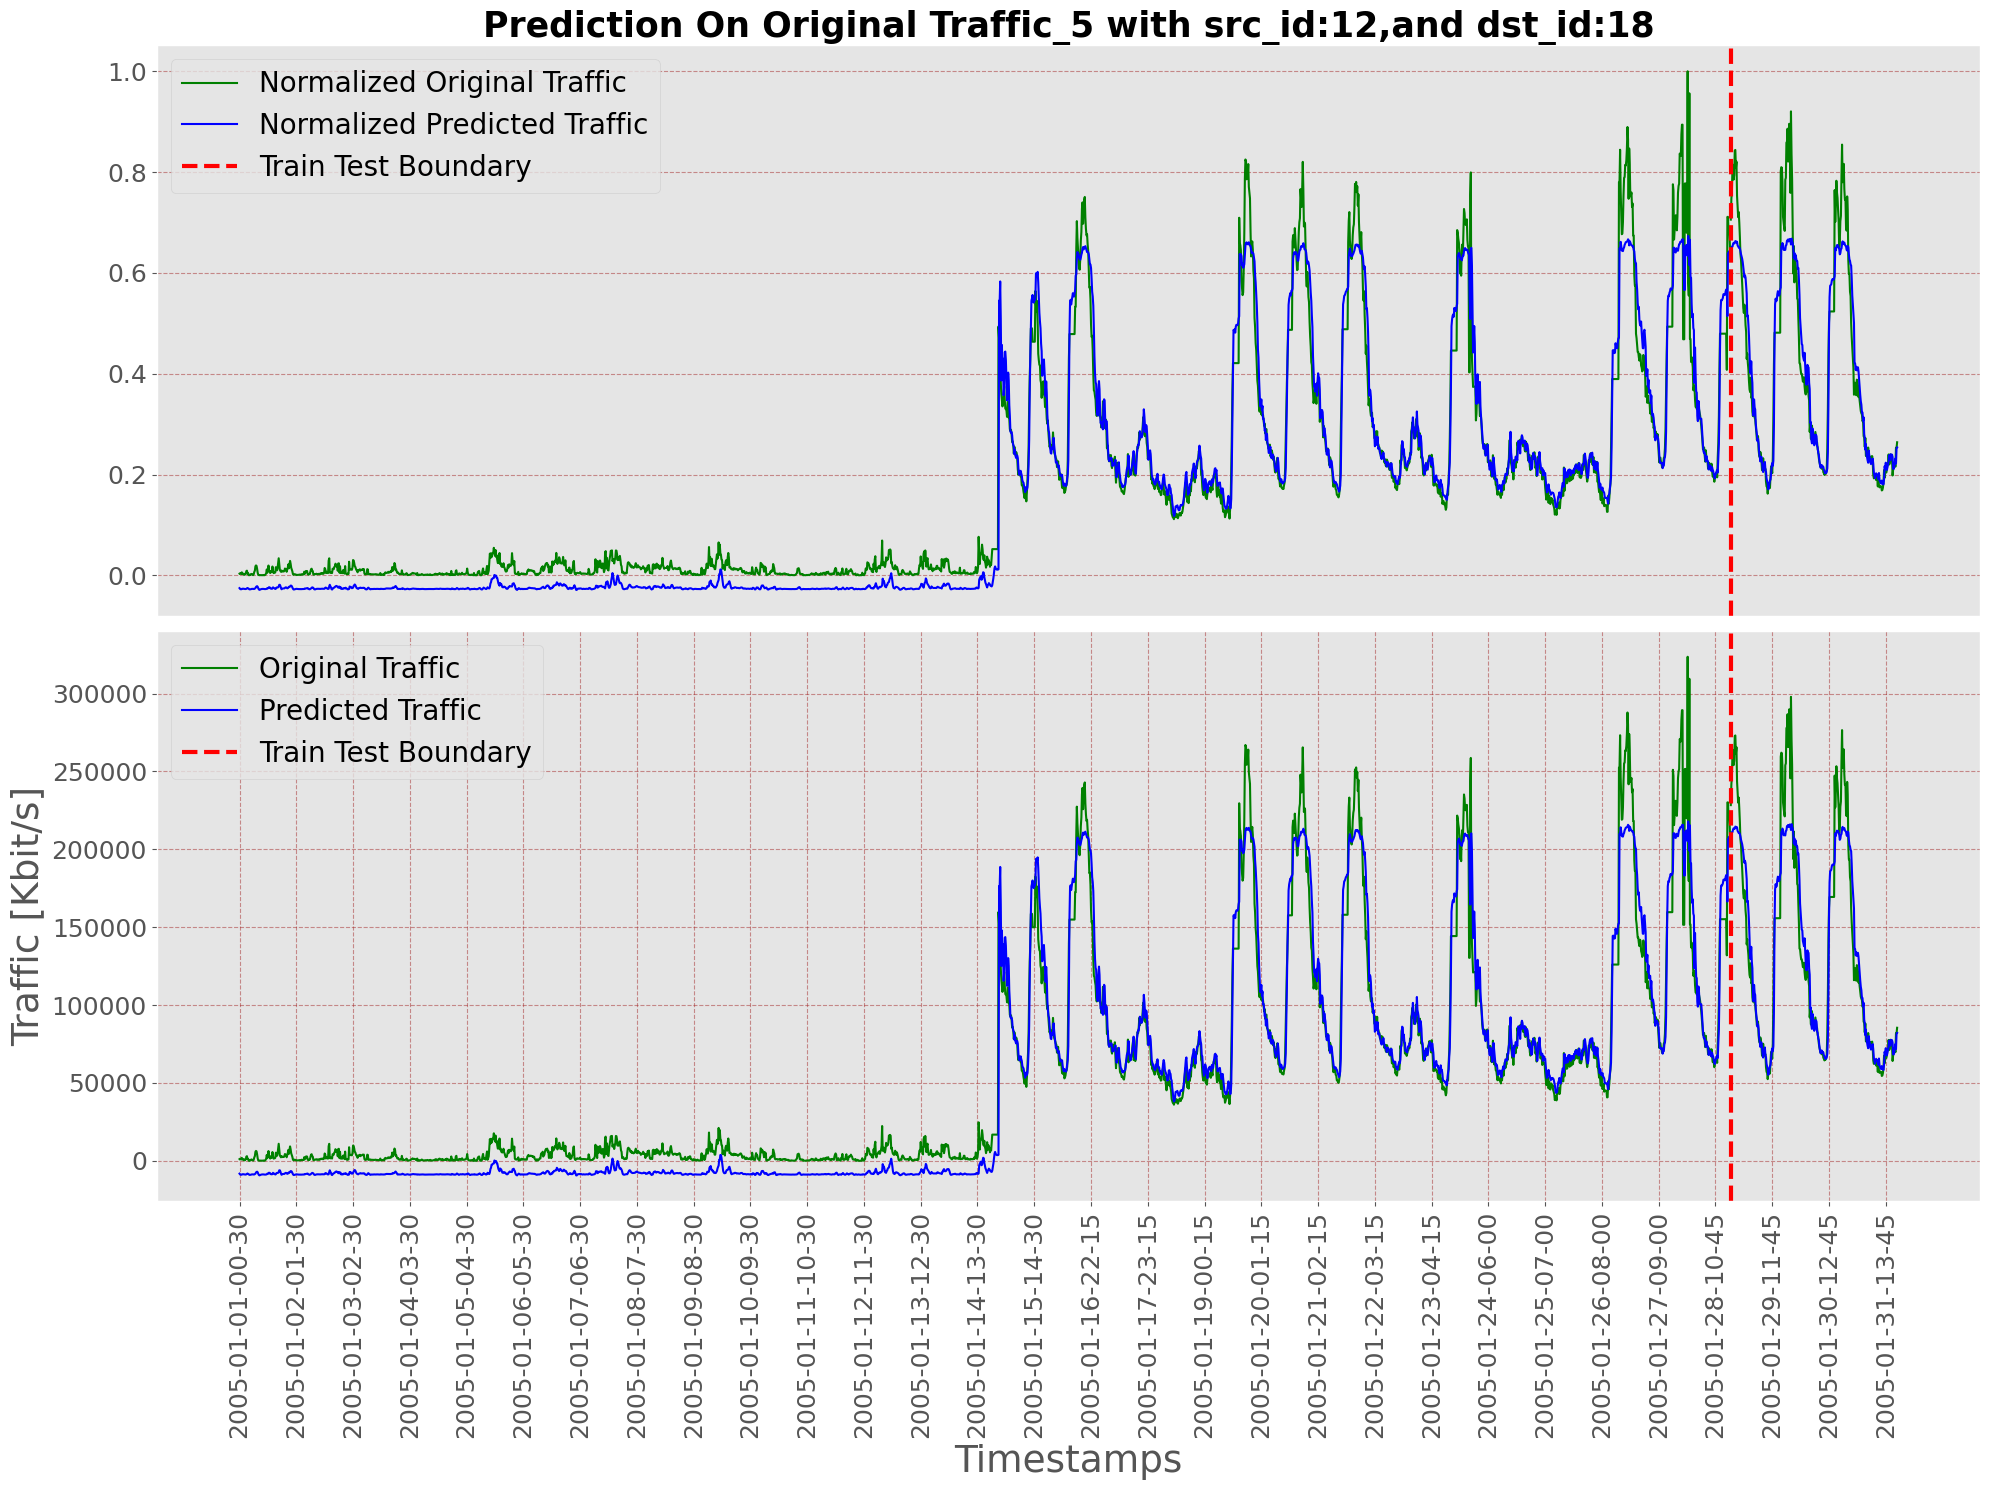

In [ ]:
index = 2

dataframe = raw_traffic_df
plot_results(scaler,cleaned_traffic_df,cleaned_traffic_df_normalized,
             rnn_without_outliers_normalized,
            train_part_dataframe_without_outliers,train_part_dataframe_without_outliers_normalized,
            test_part_dataframe_without_outliers,test_part_dataframe_without_outliers_normalized)

## f) Model_2: Local CONV_LSTM

### f_1) Define Model

In [ ]:
def CONV_LSTM(input_shape):


    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)

    # Add a final Convolution layer to match the desired output shape
    x = tfkl.Conv1D(1, 3, padding='same', name='output_layer')(x)
    output_layer = tfkl.GlobalMaxPooling1D()(x)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

### f_2) Train model

In [ ]:
# Set callbacks
print(f'This is training for traffic_{row} with outliers')
print('*'*100)

path = f"/content/CONV_LSTM_on_Original_for_traffic_{row}_with_outliers"
my_checkpoints = checkpoint(path=path,metrics='val_loss',save_weights_only=False)
my_eraly_stops = early_stopping()
my_tensors =  tensor_board(path=path)
my_defined_callbacks = [my_checkpoints, my_eraly_stops, my_tensors]

# Call model
input_shape = (window_size,1)
conv_lstm_with_outliers = CONV_LSTM(input_shape)
conv_lstm_with_outliers.summary()

# fitting the model
start = time.time()
conv_lstm_with_outliers.fit(X_train_with_outliers, y_train_with_outliers, epochs = Epochs,validation_split=0.1, batch_size = Batch_size, callbacks=my_defined_callbacks)
stop = time.time()
training_time = round((stop-start),0)

This is training for traffic_5 with outliers
****************************************************************************************************


Model: "CONV_LSTM_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm              │ (None, 20, 128)        │        33,792 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv (Conv1D)                   │ (None, 20, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Conv1D)           │ (None, 20, 1)          │           385 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 1)              │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,457 (326.00 KB)

 Trainable params: 83,457 (326.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
1179/1182 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 380584568291328.0000
Epoch 1: val_loss improved from inf to 24512133120.00000, saving model to Checkpint_Folder/CONV_LSTM_on_Original_for_traffic_5_with_outliers/cp.keras
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 381645391659008.0000 - val_loss: 24512133120.0000
Epoch 2/200
1175/1182 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 379508242776064.0000
Epoch 2: val_loss improved from 24512133120.00000 to 24507887616.00000, saving model to Checkpint_Folder/CONV_LSTM_on_Original_for_traffic_5_with_outliers/cp.keras
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 381644687015936.0000 - val_loss: 24507887616.0000
Epoch 3/200
1174/1182 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 379238867795968.0000
Epoch 3: val_loss did not improve from 24507887616.00000
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 381646599618560.0000 - val_loss: 25735538688.0000
Epoch 4/200
1176/1182 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 379780637

### f_3) Result

In [ ]:
# Prediction and performance on dataset with outliers
y_test_pred_with_outliers = conv_lstm_with_outliers.predict(X_test_with_outliers)


conv_lstm_perforamnce_with_outliers = performance(model_name='Model_2: CONV_LSTM',prediction_type='Prediction_on_Original',operations_on_input="with_outliers",row = row,
                                            y_true=y_test_with_outliers,
                                            y_pred=y_test_pred_with_outliers,training_time=training_time )


conv_lstm_perforamnce_with_outliers.reset_index(inplace=True)
conv_lstm_perforamnce_with_outliers.drop(['index'],axis= 1,inplace=True)
display(conv_lstm_perforamnce_with_outliers)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


,Traffic_id,Src_id,Dst_id,Model,Prediction_type,Input,Training_time[s],MAE,MSE,MAPE[%]
0,5,12.0,18.0,Model_2: CONV_LSTM,Prediction_on_Original,with_outliers,97.0,129941.104045,2.188556e+10,96.448757


### f_4) Effect of removing outliers

In [ ]:
# Call section c) Split dataset to train and test without ouliers
print('For cleaned_traffic_df')
print('*'*100)
train_part_dataframe_without_outliers, test_part_dataframe_without_outliers = split_train_test(row,split_train_test_portion=split_train_test_portion,
                                                                                               dataframe=cleaned_traffic_df)

# Call section d) Prepare X_train and y_train

X_train_without_outliers, y_train_without_outliers,X_test_without_outliers, y_test_without_outliers = create_sequences(train_part_dataframe=train_part_dataframe_without_outliers,
                                                                                                                       test_part_dataframe=test_part_dataframe_without_outliers,
                                                                                                                       row=row, window_size=window_size)



print(f'\n\nThese information are for traffic {row} without_outliers.')
print('*'*100)
print('X_train.shape: ',X_train_without_outliers.shape)
print('Y_train.shape: ',y_train_without_outliers.shape)
print('X_test.shape: ',X_test_without_outliers.shape)
print('Y_test.shape: ',y_test_without_outliers.shape)


# Call section f_2) Train model
print(f'This is training for traffic_{row} without outliers.')
print('*'*100)
path = f"/content/CONV_LSTM_on_Original_for_traffic_{row}_without_outliers"
my_checkpoints = checkpoint(path=path,metrics='val_loss',save_weights_only=False)
my_eraly_stops = early_stopping()
my_tensors =  tensor_board(path=path)
my_defined_callbacks = [my_checkpoints, my_eraly_stops, my_tensors]

input_shape = (window_size,1)
conv_lstm_without_outliers = CONV_LSTM(input_shape)
conv_lstm_without_outliers.summary()
start = time.time()
conv_lstm_without_outliers.fit(X_train_without_outliers, y_train_without_outliers, epochs=Epochs,validation_split=0.1, batch_size = Batch_size, callbacks=my_defined_callbacks)
stop = time.time()
training_time = round((stop-start),0)


For cleaned_traffic_df
****************************************************************************************************
train_part_dataframe.shape:  (2647,)
test_part_dataframe.shape:  (294,)


These information are for traffic 5 without_outliers.
****************************************************************************************************
X_train.shape:  (2627, 20, 1)
Y_train.shape:  (2627, 1)
X_test.shape:  (274, 20, 1)
Y_test.shape:  (274, 1)
This is training for traffic_5 without outliers.
****************************************************************************************************


Model: "CONV_LSTM_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm              │ (None, 20, 128)        │        33,792 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv (Conv1D)                   │ (None, 20, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Conv1D)           │ (None, 20, 1)          │           385 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 1)              │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,457 (326.00 KB)

 Trainable params: 83,457 (326.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
1180/1182 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5059345920.0000
Epoch 1: val_loss improved from inf to 21705906176.00000, saving model to Checkpint_Folder/CONV_LSTM_on_Original_for_traffic_5_without_outliers/cp.keras
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 5059794432.0000 - val_loss: 21705906176.0000
Epoch 2/200
1180/1182 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4871079424.0000
Epoch 2: val_loss improved from 21705906176.00000 to 19423690752.00000, saving model to Checkpint_Folder/CONV_LSTM_on_Original_for_traffic_5_without_outliers/cp.keras
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 4871471104.0000 - val_loss: 19423690752.0000
Epoch 3/200
1175/1182 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4476399104.0000
Epoch 3: val_loss improved from 19423690752.00000 to 19265820672.00000, saving model to Checkpint_Folder/CONV_LSTM_on_Original_for_traffic_5_without_outliers/cp.keras
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 4478576128.0000 - val_loss: 1926

In [ ]:
# Call f_3) Result
y_test_pred_without_outliers = conv_lstm_without_outliers.predict(X_test_without_outliers)
conv_lstm_perforamnce_without_outliers = performance(model_name='Model_2: CONV_LSTM',prediction_type='Prediction_on_Original',operations_on_input="without_outliers",row = row,
                                            y_true=y_test_without_outliers,
                                            y_pred=y_test_pred_without_outliers,training_time=training_time )

conv_lstm_perforamnce_without_outliers = pd.concat([conv_lstm_perforamnce_with_outliers,conv_lstm_perforamnce_without_outliers],axis =0)

conv_lstm_perforamnce_without_outliers.reset_index(inplace=True)
conv_lstm_perforamnce_without_outliers.drop(['index'],axis= 1,inplace=True)
display(conv_lstm_perforamnce_without_outliers)



9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


,Traffic_id,Src_id,Dst_id,Model,Prediction_type,Input,Training_time[s],MAE,MSE,MAPE[%]
0,5,12.0,18.0,Model_2: CONV_LSTM,Prediction_on_Original,with_outliers,97.0,129941.104045,2.188556e+10,96.448757
1,5,12.0,18.0,Model_2: CONV_LSTM,Prediction_on_Original,without_outliers,238.0,93226.757085,1.307787e+10,64.668856


In [ ]:
conv_lstm_perforamnce_without_outliers

,Traffic_id,Src_id,Dst_id,Model,Prediction_type,Input,Training_time[s],MAE,MSE,MAPE[%]
0,5,12.0,18.0,Model_2: CONV_LSTM,Prediction_on_Original,with_outliers,97.0,129941.104045,2.188556e+10,96.448757
1,5,12.0,18.0,Model_2: CONV_LSTM,Prediction_on_Original,without_outliers,238.0,93226.757085,1.307787e+10,64.668856


### f_5) Effect of Normalizing

In [ ]:

# Call section c)Split datsaset to train and test with normalization=True


train_part_dataframe_without_outliers_normalized, test_part_dataframe_without_outliers_normalized,scaler = split_train_test(row,split_train_test_portion=split_train_test_portion,
                                                                                               dataframe=cleaned_traffic_df,
                                                                                               normalization=True)


# Call section d) Prepare X_train and y_train
X_train_without_outliers_normalized, y_train_without_outliers_normalized,X_test_without_outliers_normalized, y_test_without_outliers_normalized = create_sequences(train_part_dataframe=train_part_dataframe_without_outliers_normalized,
                                                                                                                       test_part_dataframe=test_part_dataframe_without_outliers_normalized,
                                                                                                                       row=row, window_size=window_size)

print(f'\n\nThese information are for traffic {row} without_outliers with noramlization.')
print('*'*100)
print('X_train.shape: ',X_train_without_outliers_normalized.shape)
print('Y_train.shape: ',y_train_without_outliers_normalized.shape)
print('X_test.shape: ',X_test_without_outliers_normalized.shape)
print('Y_test.shape: ',y_test_without_outliers_normalized.shape)

# Call section e_2) Train model

print(f'This is training for traffic_{row} without outliers and normalized')
print('*'*100)
path = f"/content/CONV_LSTM_on_residuals_for_traffic_{row}_without_outliers_normalized"
my_checkpoints = checkpoint(path=path,metrics='val_loss',save_weights_only=False)
my_eraly_stops = early_stopping()
my_tensors =  tensor_board(path=path)
my_defined_callbacks = [my_checkpoints, my_eraly_stops, my_tensors]

# Call section e_3) Result
conv_lstm_without_outliers_normalized = CONV_LSTM(input_shape)
conv_lstm_without_outliers_normalized.summary()
start = time.time()
conv_lstm_without_outliers_normalized.fit(X_train_without_outliers_normalized, y_train_without_outliers_normalized, epochs = Epochs,validation_split=0.1, batch_size = Batch_size, callbacks=my_defined_callbacks)
stop = time.time()
training_time = round((stop-start),0)



train_part_dataframe.shape:  (2647,)
test_part_dataframe.shape:  (294,)


These information are for traffic 5 without_outliers with noramlization.
****************************************************************************************************
X_train.shape:  (2627, 20, 1)
Y_train.shape:  (2627, 1)
X_test.shape:  (274, 20, 1)
Y_test.shape:  (274, 1)
This is training for traffic_5 without outliers and normalized
****************************************************************************************************


Model: "CONV_LSTM_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm              │ (None, 20, 128)        │        33,792 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv (Conv1D)                   │ (None, 20, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Conv1D)           │ (None, 20, 1)          │           385 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 1)              │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,457 (326.00 KB)

 Trainable params: 83,457 (326.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
1178/1182 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0024
Epoch 1: val_loss improved from inf to 0.00730, saving model to Checkpint_Folder/CONV_LSTM_on_residuals_for_traffic_5_without_outliers_normalized/cp.keras
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0024 - val_loss: 0.0073
Epoch 2/200
1180/1182 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.0606e-04
Epoch 2: val_loss did not improve from 0.00730
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 6.0659e-04 - val_loss: 0.0084
Epoch 3/200
1177/1182 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.1031e-04
Epoch 3: val_loss did not improve from 0.00730
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 5.1143e-04 - val_loss: 0.0088
Epoch 4/200
1176/1182 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8147e-04
Epoch 4: val_loss did not improve from 0.00730
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 4.8273e-04 - val_loss: 0.0105
Epoch 5/200
1177/1182 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.9082e-04
Epoch 5: val_loss

In [ ]:
y_test_pred_without_outliers_normalized = conv_lstm_without_outliers_normalized.predict(X_test_without_outliers_normalized)
conv_lstm_performance_without_outliers_normalized = performance(model_name='Model_2: CONV_LSTM',
                                               prediction_type='Prediction_on_Original',
                                               operations_on_input="normalized_without_outliers",row = row,
                                               y_true=y_test_without_outliers_normalized,
                                               y_pred=y_test_pred_without_outliers_normalized,training_time=training_time )

conv_lstm_performance_without_outliers_normalized = pd.concat([conv_lstm_perforamnce_without_outliers,conv_lstm_performance_without_outliers_normalized],axis =0)
display(conv_lstm_performance_without_outliers_normalized)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


,Traffic_id,Src_id,Dst_id,Model,Prediction_type,Input,Training_time[s],MAE,MSE,MAPE[%]
0,5,12.0,18.0,Model_2: CONV_LSTM,Prediction_on_Original,with_outliers,97.0,129941.104045,2.188556e+10,96.448757
1,5,12.0,18.0,Model_2: CONV_LSTM,Prediction_on_Original,without_outliers,238.0,93226.757085,1.307787e+10,64.668856
0,5,12.0,18.0,Model_2: CONV_LSTM,Prediction_on_Original,normalized_without_outliers,77.0,0.055139,4.539699e-03,14.349007


###

hi
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


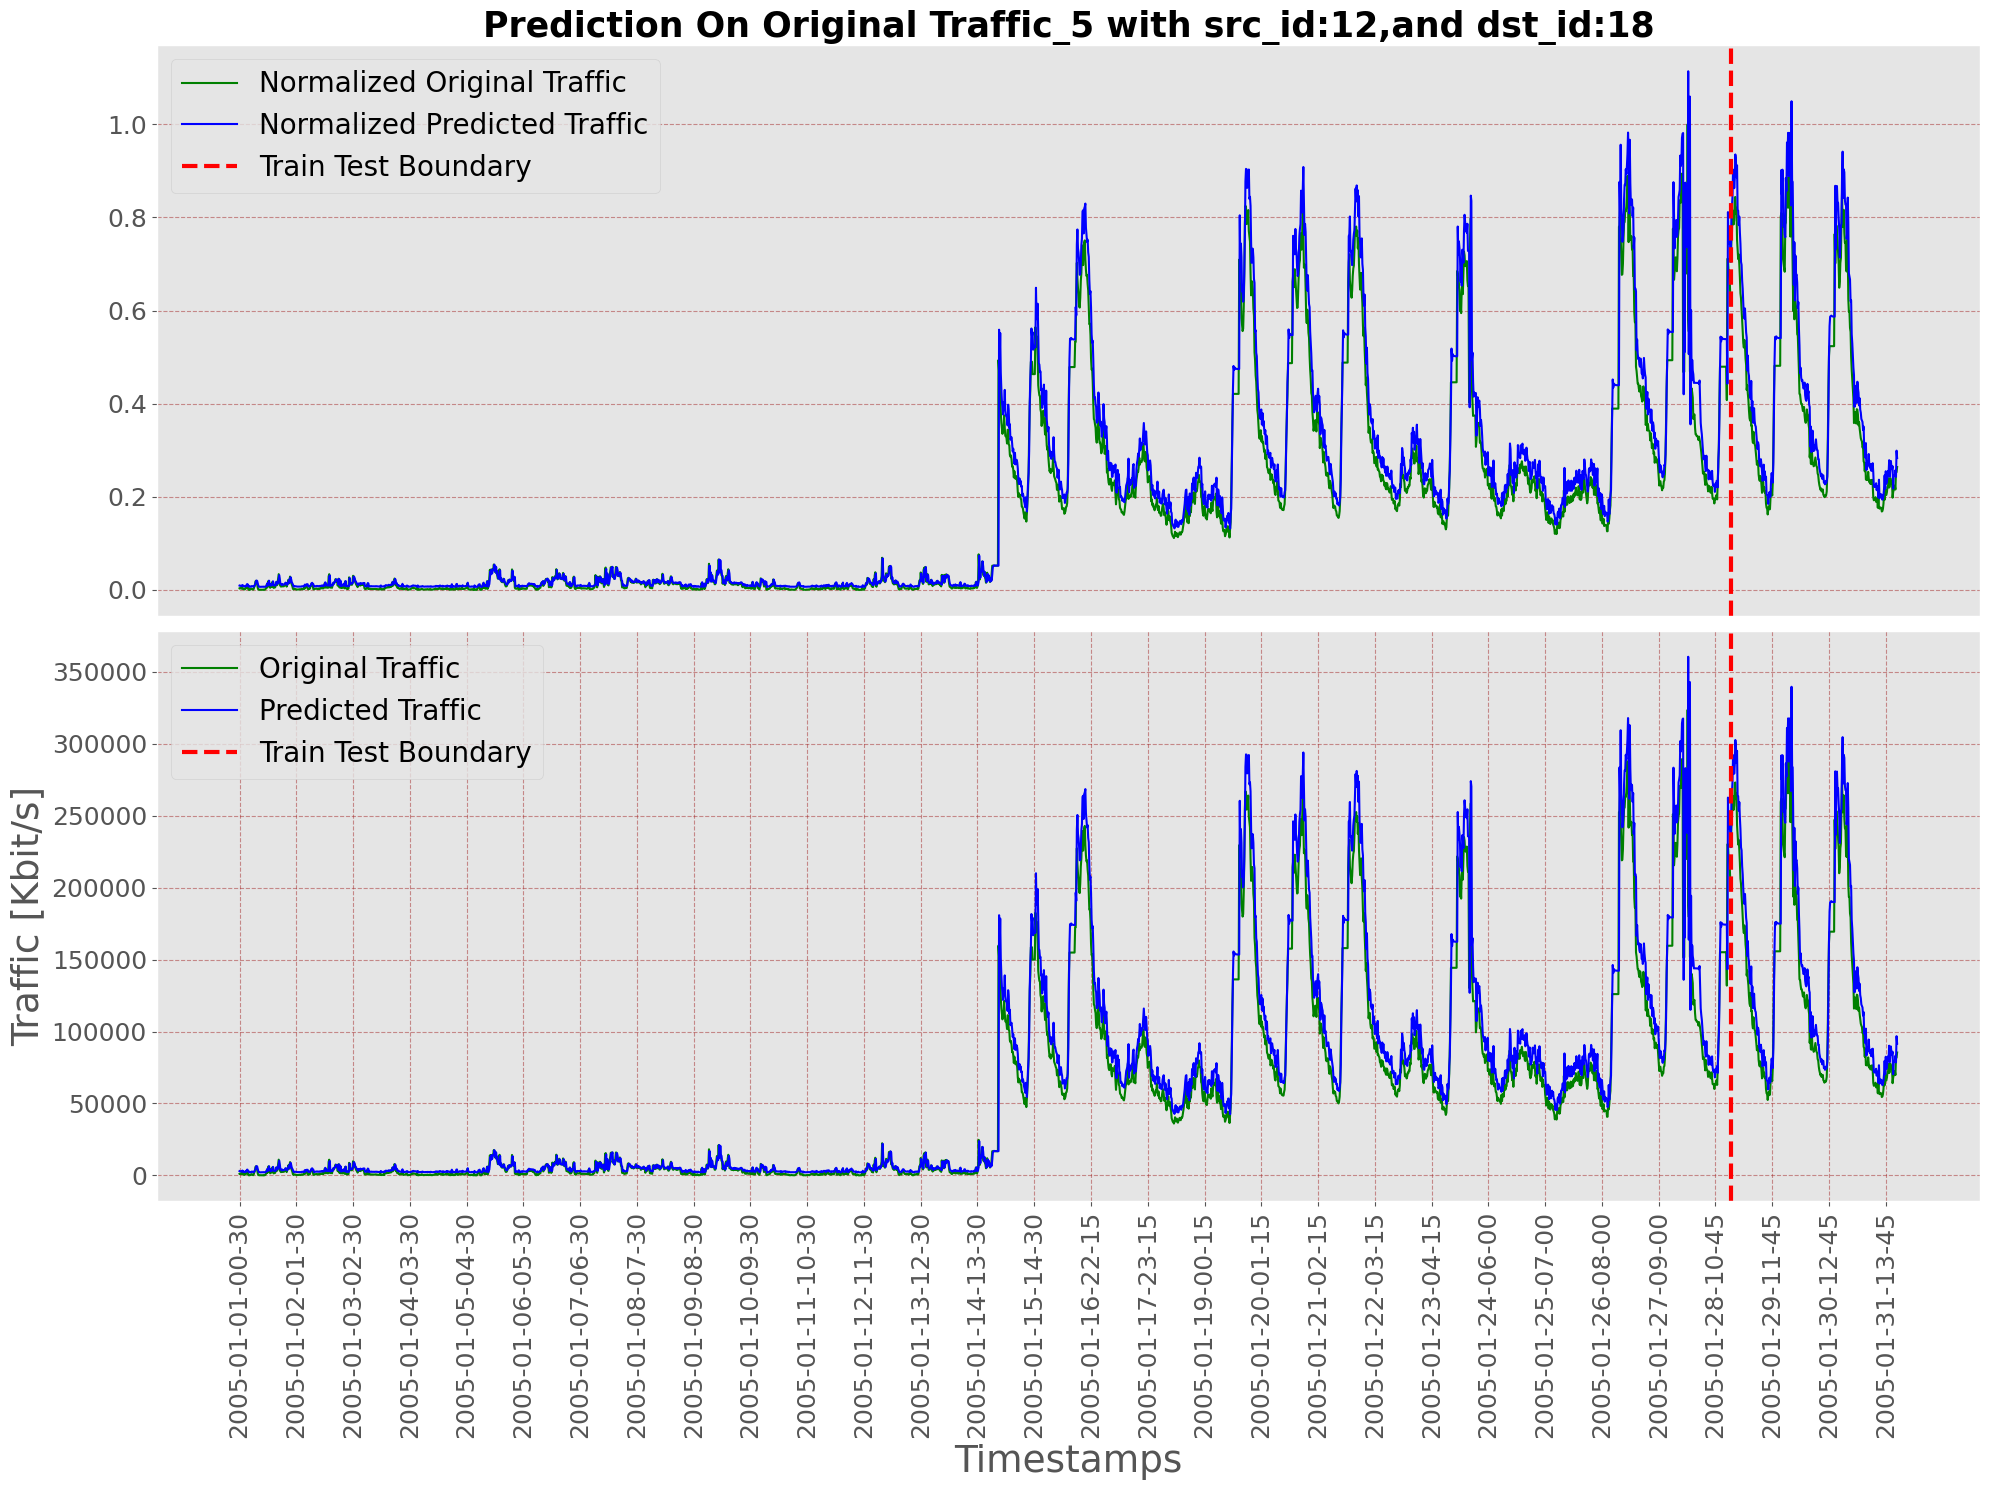

In [ ]:
index = 2

dataframe = raw_traffic_df
plot_results(scaler,cleaned_traffic_df,cleaned_traffic_df_normalized,
             conv_lstm_without_outliers_normalized,
            train_part_dataframe_without_outliers,train_part_dataframe_without_outliers_normalized,
            test_part_dataframe_without_outliers,test_part_dataframe_without_outliers_normalized)

In [ ]:
conv_lstm_performance_without_outliers_normalized.to_csv('Performance_df_of_CONV_LSTM_on_Orginal.csv',index=True)